# Imports & Data

## Modules & Functions

In [2]:
import sys
import numpy as np
import gc
from scipy.stats import norm
import pandas as pd
from scipy.optimize import curve_fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalog4FGL, SourceCatalog, SourceCatalog1LHAASO
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
from regions import CircleSkyRegion, RectangleSkyRegion, RectanglePixelRegion, PixCoord
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset
from scipy import constants
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, FoVBackgroundModel, Models, SmoothBrokenPowerLawSpectralModel, Shell2SpatialModel
from gammapy.estimators import FluxPoints,FluxPointsEstimator, ExcessMapEstimator
%matplotlib inline
import sys, os
import numpy as np
import itertools
import re
import datetime
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import gammapy
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import json
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import CashCountsStatistic, cash, cash_sum_cython
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets, FluxPointsDataset, MapDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, DiskSpatialModel, TemplateSpatialModel, PowerLawNormSpectralModel, BrokenPowerLawSpectralModel, SmoothBrokenPowerLawSpectralModel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion, EllipseSkyRegion
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
    EnergyDependentMorphologyEstimator)
from gammapy.modeling.models import FoVBackgroundModel, GaussianSpatialModel, ShellSpatialModel, DiskSpatialModel, PiecewiseNormSpectralModel, GeneralizedGaussianSpatialModel, ExpCutoffPowerLawSpectralModel
from gammapy.makers import FoVBackgroundMaker
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxMaps
from gammapy.maps import WcsNDMap
from gammapy.visualization import plot_npred_signal, plot_distribution
import ipywidgets
from gammapy.modeling.models import Models
from astropy.coordinates import Angle
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
from scipy.stats import chi2, norm
from astropy.table import Table
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import sys  
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from PIL import Image
import my_utility_functions as muf
import os
import re
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy import table
import runmatching_utilities as util
import gappa as gp
from astropy.table import Table

from astropy.constants import M_sun
from astropy.units import Quantity
from gammapy.astro.source import PWN, SNRTrueloveMcKee, Pulsar, SimplePulsar
import emcee
import corner
import multiprocessing
from multiprocessing import Pool
import scipy.optimize as opt
import matplotlib.gridspec as gridspec

In [3]:
PlotDir = '/home/wecapstor1/caph/caph101h/software/GAMERA/lib/Plots/'

In [4]:
def MHz_to_eV(frequency_MHz):
    frequency_Hz = frequency_MHz * 1e6
    # Energy in joules
    energy_J = constants.h * frequency_Hz

    # Energy in eV
    energy_eV = energy_J / 1.602e-19
    
    return energy_eV

def flux_mJy_to_erg_cm2_s(flux_density_mJy, frequency_MHz):
    # Convert flux density to erg/s/Hz/cm^2  ---> erg/cm^2/s/Hz
    flux_density_erg = flux_density_mJy * 1e-26
    frequency_Hz = frequency_MHz * 1e6
    
    # Calculate total flux in erg/cm^2/s
    converted_flux = flux_density_erg * frequency_Hz

    return(converted_flux)

In [5]:
def red_chi2_with_model_error(data_array, model_array, data_error, model_upper, model_lower, num_fit_params):
    """
    Compute chi-squared and reduced chi-squared, including model uncertainties.

    Parameters:
    - data_array: array-like, observed data values
    - model_array: array-like, model predictions
    - data_error: array-like, uncertainties in observed data (standard deviations)
    - model_upper: array-like, model predictions at the upper parameter bounds
    - model_lower: array-like, model predictions at the lower parameter bounds
    - num_fit_params: int, number of fitted parameters

    Returns:
    - chi2: float, chi-squared value
    - chi2_red: float, reduced chi-squared value
    """
    dof = len(data_array) - num_fit_params  # Use data points, not model points

    if dof <= 0:
        raise ValueError("Degrees of freedom must be greater than zero.")

    # Calculate the model uncertainty as half the difference between upper and lower model predictions
    model_error = (model_upper - model_lower) / 2

    # Calculate total uncertainty (combining data and model errors)
    total_error = data_error ** 2 + model_error ** 2

    # Calculate chi-squared
    nominator = (data_array- model_array) ** 2
    denominator = total_error

    chi2 = np.sum(nominator / denominator)
    chi2_red = chi2 / dof

    return chi2, chi2_red

In [6]:
def pJy_to_erg(flux_pjy, energy_mev):
    """
    Convert flux from picoJanskys (pJy) to erg cm^-2 s^-1 given the energy in MeV.
    
    Parameters:
        flux_pjy (float): Flux in picoJanskys (pJy).
        energy_mev (float): Energy in MeV.
    
    Returns:
        float: Flux in erg cm^-2 s^-1.
    """
    # Constants
    planck_constant = 6.626e-27  # Planck's constant in erg*s
    erg_per_mev = 1.602e-6  # Conversion factor from MeV to erg
    pjy_to_erg_cm2_s_hz = 1e-35  # Conversion from pJy to erg/cm^2/s/Hz
    
    # Convert energy to erg
    energy_erg = energy_mev * erg_per_mev
    
    # Calculate frequency in Hz
    frequency_hz = energy_erg / planck_constant
    
    # Convert flux to erg/cm^2/s
    flux_erg_cm2_s = flux_pjy * pjy_to_erg_cm2_s_hz * frequency_hz
    
    return flux_erg_cm2_s

In [7]:
def temperature_from_energy_density(U, unit="erg/cm3"):
    """
    Compute the temperature (in Kelvin) from the energy density of a blackbody photon field.
    
    Parameters:
    -----------
    U : float or array-like
        Energy density of the photon field.
    unit : str, optional
        Unit of U. Options:
        - "J/m3"  (Joules per cubic meter)
        - "erg/cm3" (ergs per cubic centimeter, default)
    
    Returns:
    --------
    T : float or array-like
        Temperature in Kelvin.
    """
    # Radiation constant in J/m³/K⁴
    a = 7.5657e-16  # J/m³/K⁴
    
    U_SI = U * 1e-7 * 1e6  # erg/cm³ -> J/m³

    # Compute temperature
    T = (U_SI / a) ** 0.25  
    
    return T

In [8]:
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    θb = np.mean(chain, axis=1)
    θbb = np.mean(θb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((θbb - θb)**2, axis=0)
    var_θ = (n - 1) / n * W + 1 / n * B
    r_hat = np.sqrt(var_θ / W)
    return r_hat

## Loading Data

In [9]:
# Load the ECSV file using Astropy
data_table = Table.read('/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Analysis/Power_law/energy_flux_data.ecsv', format='ascii.ecsv')

# Extract the data into arrays
energy = data_table['energy']
energy_low = data_table['energy_edge_low']
energy_high = data_table['energy_edge_high']
eflux = data_table['e2dnde'].value 
eflux_error = data_table['e2dnde_err'].value

energy_mid_err = [energy_low, energy_high] 

In [10]:
catalog_4FGL = SourceCatalog4FGL('/home/wecapstor1/caph/caph101h/software/miniforge3/bin/gammapy-datasets/1.2/catalogs/fermi/gll_psc_v32.fit.gz')
source_fermi_J1048_5832 = catalog_4FGL["4FGL J1048.2-5832"]
flux_points_fermi_J1048_5832 = source_fermi_J1048_5832.flux_points
flux_points_table_fermi_J1048_5832 = source_fermi_J1048_5832.flux_points_table

# Extract flux data
flux_e2dnde_fermi_J1048_5832 = np.array(flux_points_table_fermi_J1048_5832["e2dnde"].value)[1:7] 

# Extract and handle errors
flux_e2dnde_errn_fermi_J1048_5832 = np.array(flux_points_table_fermi_J1048_5832["e2dnde_errn"].value)
flux_e2dnde_errp_fermi_J1048_5832 = np.array(flux_points_table_fermi_J1048_5832["e2dnde_errp"].value)

# Replace nan values with 0
flux_e2dnde_errn_fermi_J1048_5832 = np.nan_to_num(flux_e2dnde_errn_fermi_J1048_5832, nan=0.0)[1:7] 
flux_e2dnde_errp_fermi_J1048_5832 = np.nan_to_num(flux_e2dnde_errp_fermi_J1048_5832, nan=0.0)[1:7] 

flux_e2dnde_err_fermi_J1048_5832 = [flux_e2dnde_errn_fermi_J1048_5832, flux_e2dnde_errp_fermi_J1048_5832]

flux_e2dnde_err_fermi_J1048_5832 = np.maximum(flux_e2dnde_err_fermi_J1048_5832[0], flux_e2dnde_err_fermi_J1048_5832[1])

# Extract energy information
ref_energy_min_fermi_J1048_5832 = np.array(source_fermi_J1048_5832.flux_points.energy_min.value)[1:7] *1e-6
ref_energy_max_fermi_J1048_5832 = np.array(source_fermi_J1048_5832.flux_points.energy_max.value)[1:7] *1e-6
ref_energy_fermi_J1048_5832 =  np.array(source_fermi_J1048_5832.flux_points.energy_ref.value)[1:7] *1e-6

ref_energy_fermi_J1048_5832_err = [ref_energy_fermi_J1048_5832 - ref_energy_min_fermi_J1048_5832, ref_energy_max_fermi_J1048_5832 - ref_energy_fermi_J1048_5832] 

In [11]:
# ATNF , https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=2.5.1&startUserDefined=true&sort_attr=jname&sort_order=asc&condition=&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&pulsar_names=B1046-58%0D%0A&ephemeris=long&ephemeris_submit=&style=long+with+errors&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query
atnf_frequency = np.array([700, 800, 1400, 3000]) # MHz
atnf_flux_density_mJy = np.array([12, 13.5, 9.1, 6.2])
atnf_flux_density_mJy_error = np.array([1, 0.9, 0.5, 0.5])

atnf_energy = MHz_to_eV(atnf_frequency)*1e-12
atnf_flux_density_erg = flux_mJy_to_erg_cm2_s(atnf_flux_density_mJy, atnf_frequency)
atnf_flux_density_erg_error = flux_mJy_to_erg_cm2_s(atnf_flux_density_mJy_error, atnf_frequency)

In [12]:
# https://arxiv.org/abs/1812.04038

UTMOST_frequency = np.array([843]) # MHz
UTMOST_flux_density_mJy = np.array([13.5])
UTMOST_flux_density_mJy_error = np.array([0.9])

UTMOST_energy = MHz_to_eV(UTMOST_frequency)*1e-12
UTMOST_flux_density_erg = flux_mJy_to_erg_cm2_s(UTMOST_flux_density_mJy, UTMOST_frequency)
UTMOST_flux_density_erg_error = flux_mJy_to_erg_cm2_s(UTMOST_flux_density_mJy_error, UTMOST_frequency)

In [13]:
# Define the model
model = PowerLawSpectralModel(index=1.7, amplitude=1.59e-5 * u.Unit("keV-1 cm-2 s-1"), reference=1 * u.keV)
model_upper_limit = PowerLawSpectralModel(index=2.1, amplitude=2.70e-05 * u.Unit("keV-1 cm-2 s-1"), reference=1 * u.keV) 
model_lower_limit = PowerLawSpectralModel(index=1.5, amplitude=1.27e-05* u.Unit("keV-1 cm-2 s-1"), reference=1 * u.keV)

# Define a MapAxis for energy bins
energy_edges = np.linspace(0.5, 10, 2) * u.keV  # Logarithmic energy edges from 1 keV to 10 keV
energy_axis = MapAxis.from_edges(edges=energy_edges, unit="keV", name="energy")


# Compute reference fluxes
fluxes = model.reference_fluxes(energy_axis)
fluxes_upper_limit = model_upper_limit.reference_fluxes(energy_axis)
fluxes_lower_limit = model_lower_limit.reference_fluxes(energy_axis)


f_unabsorbed_recalculated = model.energy_flux_error(0.5*u.keV, 10*u.keV).value*1.6021766e-9*1e13
f_unabsorbed_recalculated_upper_limit = model_upper_limit.energy_flux_error(0.5*u.keV, 10*u.keV).value*1.6021766e-9*1e13
f_unabsorbed_recalculated_lower_limit = model_lower_limit.energy_flux_error(0.5*u.keV, 10*u.keV).value*1.6021766e-9*1e13

energy_chandra = fluxes["e_ref"].value*1e-9
energy_chandra_err = [fluxes["e_min"].value*1e-9, fluxes["e_max"].value*1e-9]
e2dnde_chandra = fluxes["ref_e2dnde"].value*1.6021766e-9

print(f"Chandra/XMM unabsorbed flux: 1.0 pm 0.45 e-13 erg cm-2 s-1")
print(f"Own Unabsorbed flux: {round(f_unabsorbed_recalculated[0],3)} pm {round(f_unabsorbed_recalculated[1],2)} 1e-13 erg cm-2 s-1")
print("Reference energies [TeV]:", energy_chandra )
print("Reference e2dnde [erg cm-2 s-1]:", e2dnde_chandra)
print("\n")

energy_chandra_upper_limit = fluxes_upper_limit["e_ref"].value*1e-9
e2dnde_chandra_upper_limit = fluxes_upper_limit["ref_e2dnde"].value*1.6021766e-9

print(f"Own Upper flux: {round(f_unabsorbed_recalculated_upper_limit[0],3)} pm {round(f_unabsorbed_recalculated_upper_limit[1],2)} 1e-13 erg cm-2 s-1")
print("Upper reference energies [TeV]:", energy_chandra_upper_limit )
print("Upper reference e2dnde [erg cm-2 s-1]:", e2dnde_chandra_upper_limit)
print("\n")

energy_chandra_lower_limit = fluxes_lower_limit["e_ref"].value*1e-9
e2dnde_chandra_lower_limit = fluxes_lower_limit["ref_e2dnde"].value*1.6021766e-9

print(f"Own Lower flux: {round(f_unabsorbed_recalculated_lower_limit[0],3)} pm {round(f_unabsorbed_recalculated_lower_limit[1],2)} 1e-13 erg cm-2 s-1")
print("Lower eference energies [TeV]:", energy_chandra_lower_limit)
print("Lower eference e2dnde [erg cm-2 s-1]:", e2dnde_chandra_lower_limit)

e2dnde_chandra_errors = np.maximum(e2dnde_chandra_upper_limit, e2dnde_chandra_lower_limit)

Chandra/XMM unabsorbed flux: 1.0 pm 0.45 e-13 erg cm-2 s-1
Own Unabsorbed flux: 1.005 pm 0.0 1e-13 erg cm-2 s-1
Reference energies [TeV]: [5.25e-09]
Reference e2dnde [erg cm-2 s-1]: [4.18943349e-14]


Own Upper flux: 1.2 pm 0.0 1e-13 erg cm-2 s-1
Upper reference energies [TeV]: [5.25e-09]
Upper reference e2dnde [erg cm-2 s-1]: [3.664867e-14]


Own Lower flux: 0.999 pm 0.0 1e-13 erg cm-2 s-1
Lower eference energies [TeV]: [5.25e-09]
Lower eference e2dnde [erg cm-2 s-1]: [4.66223067e-14]


In [14]:
energy_min_agile = np.array([.3, 1]) # GeV
energy_max_agile = np.array([1, 3]) # GeV
energy_mean_agile = (energy_max_agile + energy_min_agile)/2

agile_energy_error = [energy_min_agile*1e-3, energy_max_agile*1e-3] 

e2dnde_agile = np.array([4.7, 2.1]) * 1e-8 * energy_mean_agile**2 * 1.6022e-3
e2dnde_agile_error = np.array([.9, .65]) * 1e-8 * energy_mean_agile**2 * 1.6022e-3

In [15]:
# https://iopscience.iop.org/article/10.1086/308139/pdf
asca_energy = np.array([6e-9])
asca_energy_min = np.array([2e-9])
asca_energy_max = np.array([10e-9])

asca_energy_error = [asca_energy - asca_energy_min, asca_energy_max - asca_energy] 

asca_flux = np.array([1.55e-13])
asca_error = 2*np.array([.19e-13])

In [16]:
egret_energy = np.array([400]) # MeV
flux_in_pJy = np.array([61.8, 55.3, 67.3, 59.7, 69.5]) * 1.7 # conversion factor to pJy
flux_in_erg = pJy_to_erg(flux_in_pJy, egret_energy)
mean_egret_flux_densities_in_erg = np.array([np.mean(flux_in_erg)])
std_egret_flux_densities_in_erg = np.array([np.std(flux_in_erg)])

# std_egret_flux_densities_in_erg = np.array([6.7, 9.7, 11.9, 8.7, 10.5])

In [17]:
x = np.concatenate([
                    atnf_energy,
                    UTMOST_energy,
                    egret_energy*1e-6,
                    asca_energy,
                    energy_chandra, 
                    energy_mean_agile*1e-3,
                    ref_energy_fermi_J1048_5832,
                    energy
                ]) * gp.TeV_to_erg

x_sync = np.concatenate([
                    atnf_energy,
                    UTMOST_energy,
                    egret_energy*1e-6,
                    asca_energy,
                    energy_chandra, 
                    energy_mean_agile*1e-3,
                    ref_energy_fermi_J1048_5832,
                ]) * gp.TeV_to_erg

x_ic = np.concatenate([
    # np.array([ref_energy_fermi_J1048_5832[5]]),
                       energy.value
                      ]) * gp.TeV_to_erg

y = np.concatenate([
                    atnf_flux_density_erg,
                    UTMOST_flux_density_erg, 
                    mean_egret_flux_densities_in_erg,
                    asca_flux,
                    e2dnde_chandra,
                    e2dnde_agile,
                    flux_e2dnde_fermi_J1048_5832,
                    eflux
                ]) # must be in erg/cm2/s

y_sync = np.concatenate([
                    atnf_flux_density_erg,
                    UTMOST_flux_density_erg, 
                    mean_egret_flux_densities_in_erg,
                    asca_flux,
                    e2dnde_chandra,
                    e2dnde_agile,
                    flux_e2dnde_fermi_J1048_5832,
                ]) 

y_ic = np.concatenate([
    # np.array([flux_e2dnde_fermi_J1048_5832[5]]),
                       eflux
                      ]) 

yerr = np.concatenate([
                    atnf_flux_density_erg_error, 
                    UTMOST_flux_density_erg_error, 
                    std_egret_flux_densities_in_erg, 
                    asca_error,
                    e2dnde_chandra_errors, 
                    e2dnde_agile_error,
                    flux_e2dnde_err_fermi_J1048_5832, 
                    eflux_error
                ]) # must be in erg/cm2/s


y_err_sync = np.concatenate([
                    atnf_flux_density_erg_error, 
                    UTMOST_flux_density_erg_error, 
                    std_egret_flux_densities_in_erg, 
                    asca_error,
                    e2dnde_chandra_errors, 
                    e2dnde_agile_error,
                    flux_e2dnde_err_fermi_J1048_5832,
                ]) 

y_err_ic = np.concatenate([
    # np.array([flux_e2dnde_err_fermi_J1048_5832[5]]),
     eflux_error]) 

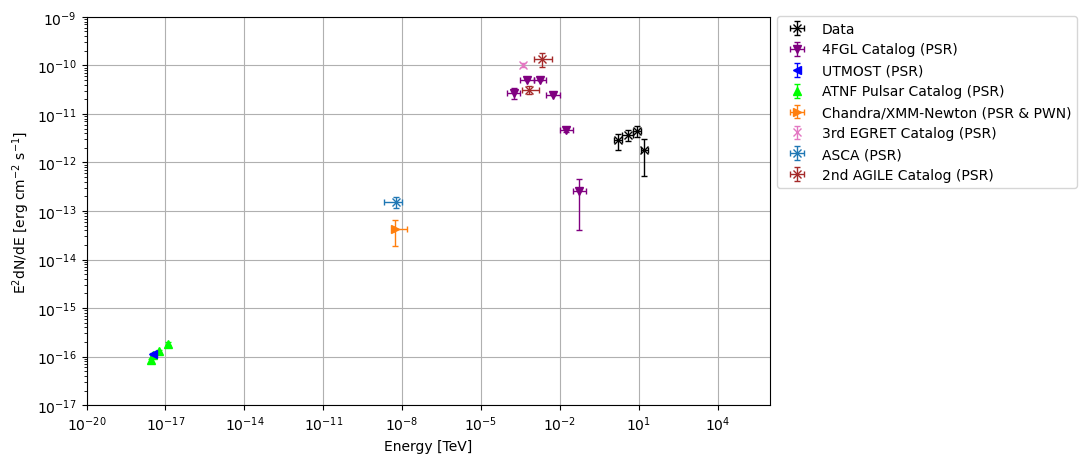

In [20]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[.5, .25, 1])  

# SED plot
ax2=plt.subplot(gs[0, 0])

# Add flux points with error bars
ax2.errorbar(energy, eflux, xerr=energy_mid_err, yerr=eflux_error, fmt='x', color='black', ecolor='black', elinewidth=1, capsize=2, label="Data")

ax2.errorbar(ref_energy_fermi_J1048_5832, flux_e2dnde_fermi_J1048_5832, xerr=ref_energy_fermi_J1048_5832_err, yerr=flux_e2dnde_err_fermi_J1048_5832, fmt='v', color='purple', ecolor='purple', elinewidth=1, capsize=2, label="4FGL Catalog (PSR)")

ax2.errorbar(UTMOST_energy, UTMOST_flux_density_erg, yerr=UTMOST_flux_density_erg_error, fmt='<', color='blue', ecolor='blue', elinewidth=1, capsize=2, label="UTMOST (PSR)", zorder=10) 

ax2.errorbar(atnf_energy, atnf_flux_density_erg, yerr=atnf_flux_density_erg_error, fmt='^', color='lime', ecolor='lime', elinewidth=1, capsize=2, label="ATNF Pulsar Catalog (PSR)") 

ax2.errorbar(energy_chandra, e2dnde_chandra, xerr=energy_chandra_err, yerr=e2dnde_chandra_errors/2, fmt='>', color='tab:orange', ecolor='tab:orange', elinewidth=1, capsize=2, label="Chandra/XMM-Newton (PSR & PWN)")

ax2.errorbar(egret_energy*1e-6, mean_egret_flux_densities_in_erg, yerr=std_egret_flux_densities_in_erg, fmt='x', color='tab:pink', ecolor='tab:pink', elinewidth=1, capsize=2, label="3rd EGRET Catalog (PSR)")

ax2.errorbar(asca_energy, asca_flux, xerr=asca_energy_error, yerr=asca_error, fmt='x', color='tab:blue', ecolor='tab:blue', elinewidth=1, capsize=2, label="ASCA (PSR)") # https://iopscience.iop.org/article/10.1086/308139/pdf

ax2.errorbar(energy_mean_agile*1e-3, e2dnde_agile, xerr=agile_energy_error, yerr=e2dnde_agile_error,fmt='x', color='brown', ecolor='brown', elinewidth=1, capsize=2, label="2nd AGILE Catalog (PSR)")

ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel(r"E$^2$dN/dE [erg cm$^{-2}$ s$^{-1}$]")
ax2.set_xlim(xmin=1e-20,xmax=1e6)
ax2.set_ylim(ymin=1e-17,ymax=1e-9)
ax2.legend(bbox_to_anchor=(1,1.02))
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid()

# muf.save_figures(PlotDir, name='SED_sync')

plt.show()

# Modelling

## Synchrotron Model

### Setup

In [17]:
class SYNC_MCMC_FitProcedure:
    def __init__(self, model_for_fitting):
        self.model_for_fitting = model_for_fitting

    def model_wrapper(self, energy, *params):
        return self.model_for_fitting(energy, *params)

    def log_prior(self, theta):
        """
        Uninformative flat prior.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
        """
        a, b, c = theta  # extract the parameters
        if 44 < a < 50 and 1.5 < b < 3 and -6 <= c <= -4:
            return 0
        return -np.inf
    
    def log_likelihood(self, theta, x, y, yerr):
        """
        Compute the chi2.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """

        model = self.model_wrapper(x, *theta) 

        nominator = (y - model)**2
        sigma_weighted = yerr**2 + (0.38*model)**2 

        log_l = -0.5 * np.sum(nominator / sigma_weighted)
        
        return log_l

    def log_prob(self, theta, x, y, yerr):
        """
        Compute the total log probability.
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta, x, y, yerr)

    def run(self, _energy_, _flux_, _flux_error_, _initial_guess_, _burn_in_steps_, _chain_steps_):
        with Pool(processes=4) as pool:
            
            nwalkers, ndim = 30, 3

            parameter_amplitudes = 0.1

            print(f"Start the MCMC using {nwalkers} walkers for {ndim} parameters. Parameter amplitude change: {parameter_amplitudes}")
   
            acceptance_range = (0.2, 0.5)

            moves = [
                    (emcee.moves.DEMove(), 0.5), 
                    (emcee.moves.StretchMove(a=1.8), 0.4), 
                    (emcee.moves.WalkMove(), 0.6) 
                    ]
            
            sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_prob, pool=pool, args=(_energy_, _flux_, _flux_error_), moves=moves)

            pos = np.array(_initial_guess_) + parameter_amplitudes * np.random.randn(nwalkers, ndim)  
            
            state = sampler.run_mcmc(pos, _burn_in_steps_, progress=True)  # Burn-in phase

            acceptance = sampler.acceptance_fraction
            mean_acceptance = np.mean(sampler.acceptance_fraction, axis=0)

            low_acceptance_walkers = acceptance[acceptance < acceptance_range[0]]
            high_acceptance_walkers = acceptance[acceptance > acceptance_range[1]]

            print(f"{len(low_acceptance_walkers)} low acceptance walkers: {low_acceptance_walkers}")
            print(f"{len(high_acceptance_walkers)} high acceptance walkers: {high_acceptance_walkers}")

            print(f"\n")
            
            print(f"Mean acceptance: {round(mean_acceptance, 2)} ---> fits, keeping step sizes: {parameter_amplitudes}")
            
            print(f"End burn-in phase")
            
            print(f"\n")
            
            print(f"Step sizes for each parameter: {parameter_amplitudes}")
            sampler.reset()
            
            sampler.run_mcmc(state, _chain_steps_, progress=True) 
            print(f"End MCMC")
        
        return sampler, parameter_amplitudes

In [18]:
# define reference energy as 1 TeV
e_ref = gp.TeV_to_erg

fu = gp.Utils()

def sync_model_for_fit(
    _photon_energy_, 
    a, b, c,
    return_full=False, 
):
    """
    Build a model for data fitting using a log-parabolic electron injection spectrum.
    
    Parameters:
        _photon_energy_ : array-like
            Array of photon energies (in TeV).
        a, b, c : float
            Parameters of the model to be fitted.
            - a: log10(total energy of particles) in erg.
            - b: spectral index alpha of the log-parabola.
            - c: curvature parameter beta of the log-parabola.
        return_full : bool, optional
            If True, returns full arrays (energies and fluxes). Otherwise, only fluxes.
        distance : float, optional
            Distance to the source in parsecs (default: 2900 pc).
        b_field : float, optional
            Magnetic field strength in Gauss (default: 3e-6 G).   
    Returns:
        np.ndarray
            Flux values for the specified SED type(s).
    """

    distance = 2.9e3  # pc

    # Convert input parameter `a` to total energy in erg
    e_total_logpar = 10**a
    alpha_logpar = b
    beta_logpar = 0

    # Electron energy grid in erg
    energy_in_erg_logpar = np.logspace(-2.75, 5, 400)*gp.TeV_to_erg

    logparabola = (energy_in_erg_logpar/e_ref)**-(alpha_logpar + beta_logpar * np.log10((energy_in_erg_logpar/e_ref)))
    logparabola *= e_total_logpar / fu.Integrate(list(zip(energy_in_erg_logpar,energy_in_erg_logpar * logparabola)))
    logparabola_spectrum = np.array(list(zip(energy_in_erg_logpar,logparabola)))

    b_field = 10**c # Gauss

    # Initialize radiation module
    fr = gp.Radiation()
    fr.ToggleQuietMode()
    fr.SetBField(b_field)
    fr.SetDistance(distance)
    fr.SetElectrons(logparabola_spectrum)

    # Calculate photon spectra
    fr.CalculateDifferentialPhotonSpectrum(_photon_energy_*gp.TeV_to_erg)

    rad = np.array(fr.GetSynchrotronSED())
    return (rad[:, 0], rad[:, 1]) if return_full else rad[:, 1]

### Fit

In [19]:
p1_sync = [45.025, 2.2, -5]

In [20]:
# Instantiate the MCMC procedure
mcmc_procedure_sync = SYNC_MCMC_FitProcedure(sync_model_for_fit)

burn_in_steps = 2500
total_sampling_steps = 10000

# Run MCMC
sampler_sync, parameter_amplification = mcmc_procedure_sync.run(x_sync, y_sync, y_err_sync, p1_sync, burn_in_steps, total_sampling_steps)

Start the MCMC using 30 walkers for 3 parameters. Parameter amplitude change: 0.1


100%|███████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:01<00:00, 40.88it/s]


0 low acceptance walkers: []
0 high acceptance walkers: []


Mean acceptance: 0.44 ---> fits, keeping step sizes: 0.1
End burn-in phase


Step sizes for each parameter: 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:06<00:00, 40.64it/s]


End MCMC


In [43]:
samples_flat = sampler_sync.get_chain(flat=True)
samples_non_flat = sampler_sync.get_chain(flat=False)

In [44]:
labels_sync = ["log10(Amplitude)", "alpha", "log10(B)"]
# Collect the results into a list
results_sync = []
for i, label in enumerate(labels_sync):
    mcmc = np.percentile(samples_flat[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results_sync.append([label, mcmc[1], q[1], q[0]])

# Create a DataFrame for better formatting
df_result_sync = pd.DataFrame(results_sync, columns=["Parameter", "Median", "Upper Error", "Lower Error"])

# Display the table
print(df_result_sync)

# Create a dictionary with parameter names as keys and median values as values
median_values_sync = {row["Parameter"]: row["Median"] for _, row in df_result_sync.iterrows()}
median_low_error_sync = {row["Parameter"]: row["Lower Error"] for _, row in df_result_sync.iterrows()}
median_upper_error_sync = {row["Parameter"]: row["Upper Error"] for _, row in df_result_sync.iterrows()}

          Parameter     Median  Upper Error  Lower Error
0  log10(Amplitude)  45.043208     0.119684     0.160030
1             alpha   2.175994     0.017983     0.018053
2          log10(B)  -4.926470     0.101137     0.055209


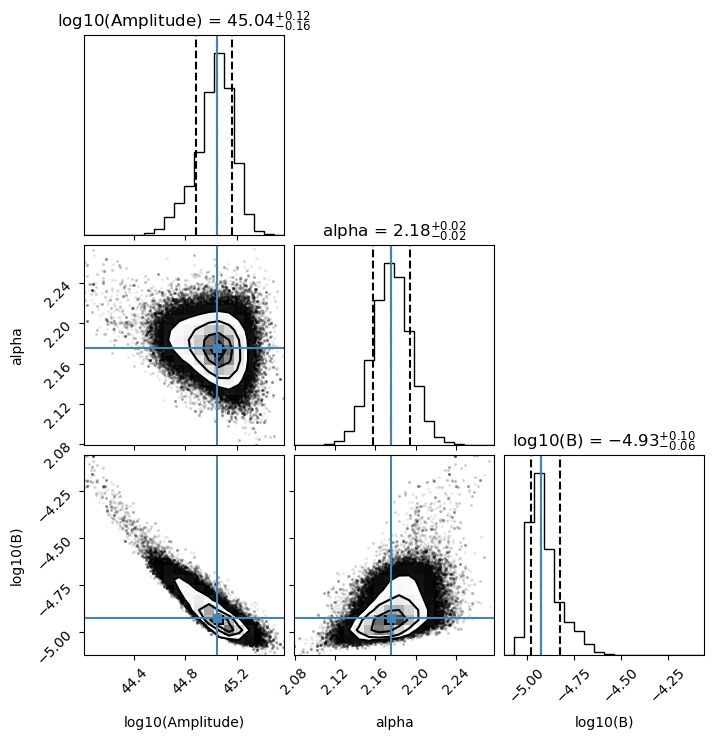

In [45]:
truth_sync = [item for item in median_values_sync.values()]

## This shows the correlation plot between the parameters
## The lines are the original true values that were used to obtain the models
fig = corner.corner(samples_flat, labels=labels_sync, truths=truth_sync, quantiles=[0.16, 0.5, 0.84], show_titles=True)

# muf.save_figures(PlotDir, name='corner_sync')

plt.show()

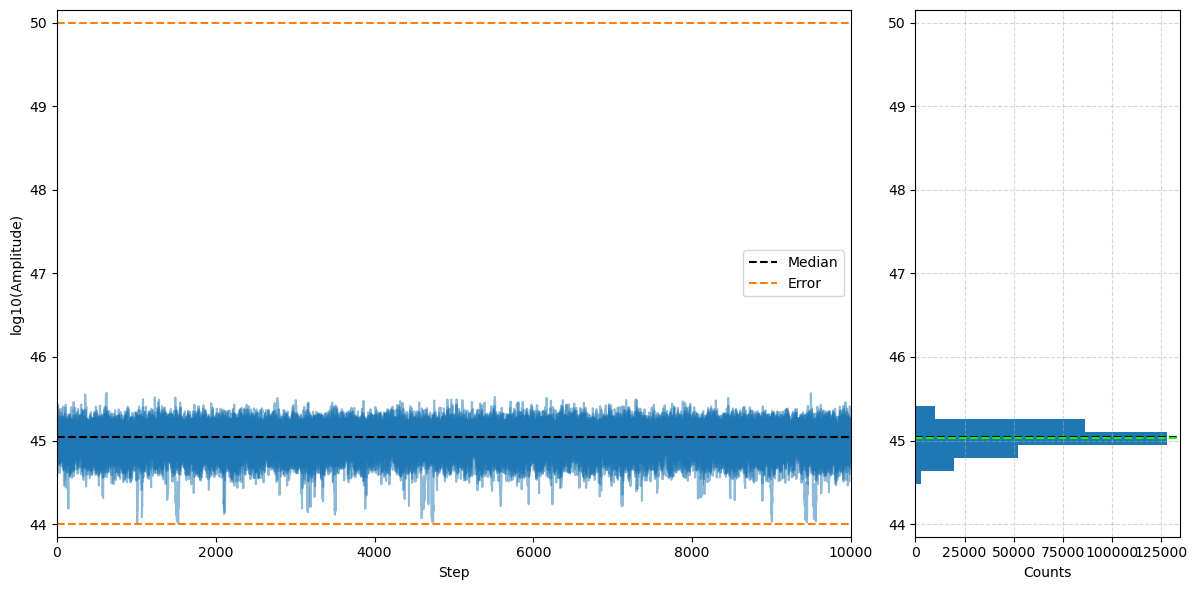

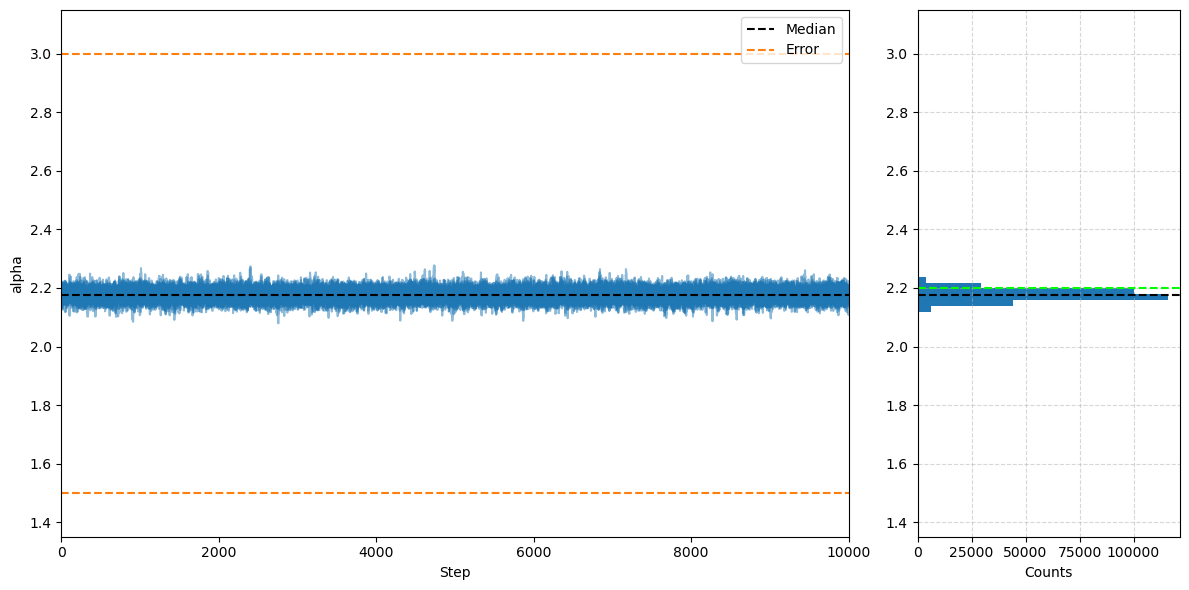

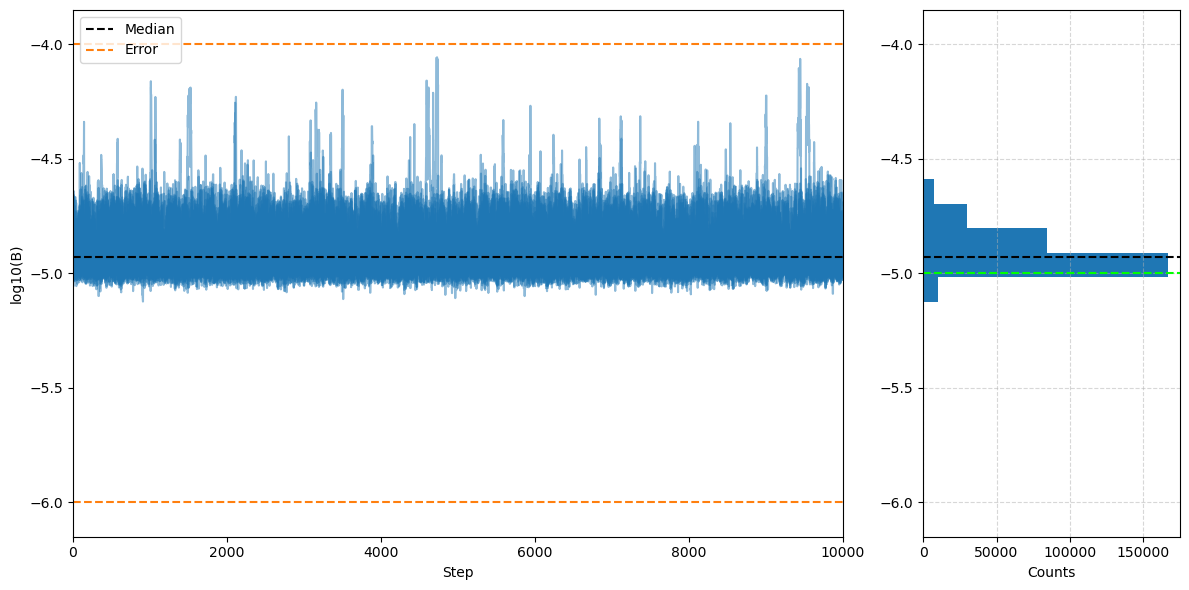

In [46]:
min_vals = [item for item in median_low_error_sync.values()]
max_vals = [item for item in median_upper_error_sync.values()]

# Define prior bounds
priors = {
    "log10(Amplitude)": (44, 50),
    "alpha": (1.5, 3),
    "log10(B)": (-6, -4),
}

# Loop over each parameter and create a trace plot + distribution plot
for i in range(len(p1_sync)):
    fig = plt.figure(figsize=(12, 6))  # Define overall figure size
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Create a grid layout (3:1 ratio)
    
    # Create trace plot (left panel)
    ax_trace = plt.subplot(gs[0])
    ax_trace.plot(samples_non_flat[:, :, i], "tab:blue", alpha=0.5)

    ax_trace.axhline(y=df_result_sync["Median"][i], color='black', linestyle='--', label='Median')
    # ax_trace.axhline(y=p1_sync[i], color='lime', linestyle='--', label='Initial')
    
    # Add the prior boundaries as horizontal lines
    param_name = labels_sync[i]  # Get the parameter name from labels_sync
    if param_name in priors:
        prior_min, prior_max = priors[param_name]
        ax_trace.axhline(y=prior_min, color='tab:orange', linestyle='--', label='Error')
        ax_trace.axhline(y=prior_max, color='tab:orange', linestyle='--')

    ax_trace.set_ylim(prior_min - 0.15, prior_max + 0.15)

    
    # Set labels and limits
    ax_trace.set_xlim(0, len(samples_non_flat))
    ax_trace.set_xlabel("Step")
    ax_trace.set_ylabel(f"{param_name}")
    ax_trace.legend()

    # Create distribution plot (right panel)
    ax_dist = plt.subplot(gs[1], sharey=ax_trace)  # Share y-axis with trace plot
    param_samples = samples_non_flat[:, :, i].flatten()

    ax_dist.hist(param_samples, bins=10, color="tab:blue", orientation="horizontal")  # Histogram
    ax_dist.axhline(y=df_result_sync["Median"][i], color='black', linestyle='--', label='Median')
    ax_dist.axhline(y=p1_sync[i], color='lime', linestyle='--', label='Initial')
    
    ax_dist.set_xlabel("Counts")
    ax_dist.yaxis.set_visible(True)  # Ensure the y-axis is visible
    ax_dist.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

    # Show the plot
    plt.tight_layout()

    # muf.save_figures(PlotDir, name=f'trace_plot_sync_{param_name}')
    
    plt.show()

In [47]:
acceptance_fraction = sampler_sync.acceptance_fraction  # Get acceptance rate for each walker
print("Mean Acceptance fraction:", round(np.mean(acceptance_fraction), 2))
print("\n")

low_acceptance_walkers = acceptance_fraction[acceptance_fraction < .2]
high_acceptance_walkers = acceptance_fraction[acceptance_fraction > .5]

print(f"{len(low_acceptance_walkers)} low acceptance walkers: {low_acceptance_walkers}")
print(f"{len(high_acceptance_walkers)} high acceptance walkers: {high_acceptance_walkers}")

Mean Acceptance fraction: 0.43


0 low acceptance walkers: []
0 high acceptance walkers: []


In [48]:
tau_sync = sampler_sync.get_autocorr_time(tol=.0, quiet=True)
print("Autocorrelation times:", tau_sync)

gl = gelman_rubin(samples_non_flat)
print("Gelman-Rubin coefficients:", gl)

Autocorrelation times: [20.42279128 18.81621355 23.21600185]
Gelman-Rubin coefficients: [1.00061447 1.00001389 1.00030408]


In [49]:
dict_results = {"Initial_Params": [], "Data_fit": [], "GR_coeff": [], "Tau_cor": [], "Parameter_amplification": []}
dict_results["Initial_Params"].append(p1_sync)
dict_results["Data_fit"].append(df_result_sync)
dict_results["GR_coeff"].append(gl)
dict_results["Tau_cor"].append(tau_sync)
dict_results["Parameter_amplification"].append(parameter_amplification)
df_results = pd.DataFrame(dict_results)

df_results.to_csv("results_fit_sync.csv", index=False)

### Plotting

In [50]:
e = np.logspace(-20, 3, 400) * gp.TeV_to_erg

In [51]:
# Extract median and error values
param_names = df_result_sync["Parameter"].values
median_values = np.array(df_result_sync["Median"].values)
upper_errors = np.array(df_result_sync["Upper Error"].values)
lower_errors = np.array(df_result_sync["Lower Error"].values)

# Compute upper and lower bounds
upper_params = median_values + upper_errors  # Upper bound (median + upper error)
lower_params = median_values - lower_errors  # Lower bound (median - lower error)

# Compute model fits for boundaries
energy_model_upper, model_upper = sync_model_for_fit(x_sync, *upper_params, return_full=True)
energy_model_lower, model_lower = sync_model_for_fit(x_sync, *lower_params, return_full=True)

energy_model_upper_to_plot, model_upper_to_plot = sync_model_for_fit(e, *upper_params, return_full=True)
energy_model_lower_to_plot, model_lower_to_plot = sync_model_for_fit(e, *lower_params, return_full=True)

In [64]:
# energy_initial_guess_sync, model_data_initial_guess_sync = sync_model_for_fit(e, *p1_sync, return_full=True)

# chi2_initial_guess_sync, chi2_red_initial_guess_sync = red_chi2(y_sync, sync_model_for_fit(x_sync, *p1_sync, return_full=False), y_err_sync, len(p1_sync))

# n_res_initial_sync = (y_sync - sync_model_for_fit(x_sync, *p1_sync, return_full=False))
# d_res_initial_sync = sync_model_for_fit(x_sync, *p1_sync, return_full=False)

# residual_initial_sync = n_res_initial_sync/y_err_sync

###########################################################################################################################################################################################

energy_mcmc_fit_sync, model_data_mcmc_fit_sync = sync_model_for_fit(e, *median_values_sync.values(), return_full=True)

chi2_mcmc_sync, chi2_red_mcmc_sync = red_chi2_with_model_error(y_sync, sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False), y_err_sync, model_upper, model_lower, len(median_values_sync.values()))

n_res_mcmc_sync =  (y_sync - sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False))
d_res_mcmc_sync = sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False)

residual_mcmc_sync = n_res_mcmc_sync/np.sqrt(y_err_sync**2 + ((model_upper-model_lower)/2)**2)

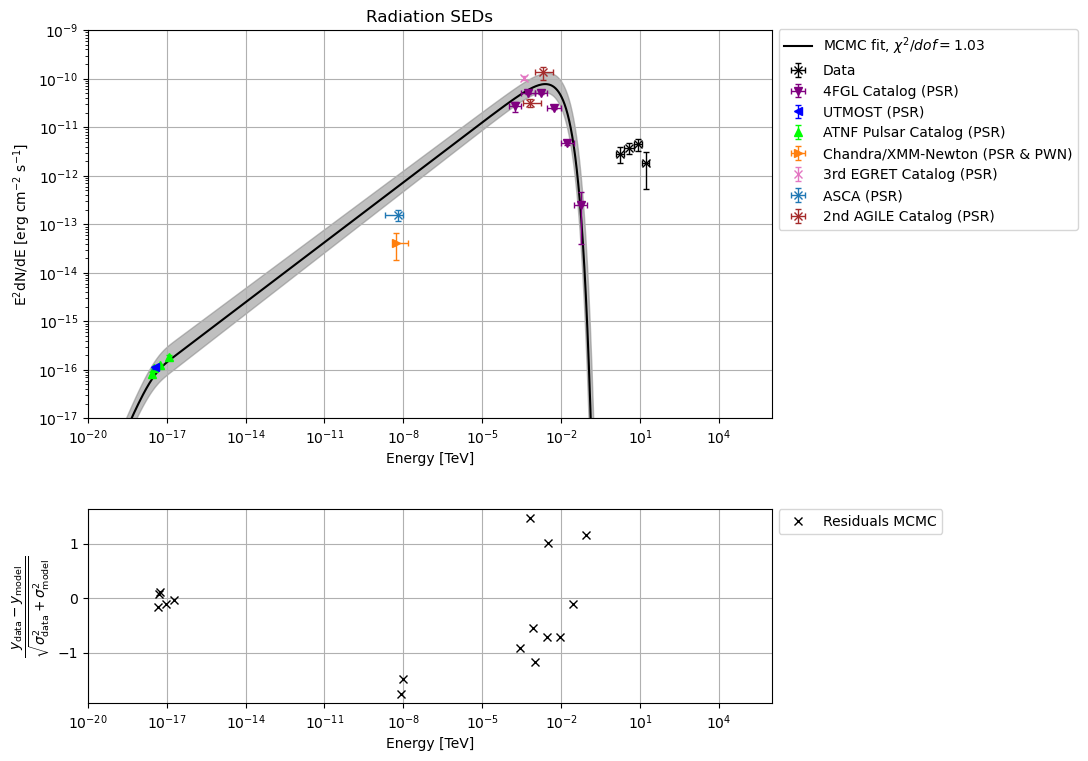

In [65]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[.5, .25, 1])  

# SED plot
ax2=plt.subplot(gs[0, 0])

# ax2.loglog(energy_initial_guess_sync, model_data_initial_guess_sync, color='blue', ls=':', label=rf'Initial guess, $\chi^2/dof = {chi2_red_initial_guess_sync:.2f}$')
ax2.loglog(energy_mcmc_fit_sync, model_data_mcmc_fit_sync, color='black', label=rf'MCMC fit, $\chi^2/dof = {chi2_red_mcmc_sync:.2f}$')

model_lower_interp = np.interp(energy_model_upper_to_plot, energy_model_lower_to_plot, model_lower_to_plot)
ax2.fill_between(energy_model_upper_to_plot, model_upper_to_plot, model_lower_interp, color="gray", alpha=.5)

# Add flux points with error bars
ax2.errorbar(energy, eflux, xerr=energy_mid_err, yerr=eflux_error, fmt='x', color='black', ecolor='black', elinewidth=1, capsize=2, label="Data")

ax2.errorbar(ref_energy_fermi_J1048_5832, flux_e2dnde_fermi_J1048_5832, xerr=ref_energy_fermi_J1048_5832_err, yerr=flux_e2dnde_err_fermi_J1048_5832, fmt='v', color='purple', ecolor='purple', elinewidth=1, capsize=2, label="4FGL Catalog (PSR)")

ax2.errorbar(UTMOST_energy, UTMOST_flux_density_erg, yerr=UTMOST_flux_density_erg_error, fmt='<', color='blue', ecolor='blue', elinewidth=1, capsize=2, label="UTMOST (PSR)", zorder=10) 

ax2.errorbar(atnf_energy, atnf_flux_density_erg, yerr=atnf_flux_density_erg_error, fmt='^', color='lime', ecolor='lime', elinewidth=1, capsize=2, label="ATNF Pulsar Catalog (PSR)") 

ax2.errorbar(energy_chandra, e2dnde_chandra, xerr=energy_chandra_err, yerr=e2dnde_chandra_errors/2, fmt='>', color='tab:orange', ecolor='tab:orange', elinewidth=1, capsize=2, label="Chandra/XMM-Newton (PSR & PWN)")

ax2.errorbar(egret_energy*1e-6, mean_egret_flux_densities_in_erg, yerr=std_egret_flux_densities_in_erg, fmt='x', color='tab:pink', ecolor='tab:pink', elinewidth=1, capsize=2, label="3rd EGRET Catalog (PSR)")

ax2.errorbar(asca_energy, asca_flux, xerr=asca_energy_error, yerr=asca_error, fmt='x', color='tab:blue', ecolor='tab:blue', elinewidth=1, capsize=2, label="ASCA (PSR)") # https://iopscience.iop.org/article/10.1086/308139/pdf

ax2.errorbar(energy_mean_agile*1e-3, e2dnde_agile, xerr=agile_energy_error, yerr=e2dnde_agile_error,fmt='x', color='brown', ecolor='brown', elinewidth=1, capsize=2, label="2nd AGILE Catalog (PSR)")

ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel(r"E$^2$dN/dE [erg cm$^{-2}$ s$^{-1}$]")
ax2.set_xlim(xmin=1e-20,xmax=1e6)
ax2.set_ylim(ymin=1e-17,ymax=1e-9)
ax2.set_title("Radiation SEDs")
ax2.legend(bbox_to_anchor=(1,1.02))
ax2.grid()

ax3 = plt.subplot(gs[1, 0])

# ax3.plot(x_sync, residual_initial_sync, 'o', color='black', label='Initial guess')

ax3.plot(x_sync, residual_mcmc_sync, 'x', color='black', label='Residuals MCMC')


ax3.set_xscale("log")
ax3.set_xlim(xmin=1e-20,xmax=1e6)
# ax3.set_ylim(ymin=-1,ymax=1)

ax3.legend(bbox_to_anchor=(1.26, 1.035))
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r'$\frac{y_{\text{data}} - y_{\text{model}}}{\sqrt{\sigma_{\text{data}}^2 + \sigma_{\text{model}}^2}}$', fontsize=14)
ax3.grid()

# muf.save_figures(PlotDir, name='SED_sync')

plt.show()

## IC Model

### Setup

In [1289]:
class IC_MCMC_FitProcedure:
    def __init__(self, model_for_fitting):
        self.model_for_fitting = model_for_fitting

    def model_wrapper(self, energy, *params):
        return self.model_for_fitting(energy, *params)

    def log_prior(self, theta):
        """
        Uninformative flat prior.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
        """
        a, b = theta  # extract the parameters
        if 44 < a < 50 and 1.5 < b < 3:
            return 0
        return -np.inf
    
    def log_likelihood(self, theta, x, y, yerr):
        """
        Compute the chi2.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """

        model = self.model_wrapper(x, *theta) 
        nominator = (y - model)**2
        sigma_weighted = yerr**2 + (0.15*model)**2 

        log_l = -0.5 * np.sum(nominator / sigma_weighted)
        
        return log_l

    def log_prob(self, theta, x, y, yerr):
        """
        Compute the total log probability.
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta, x, y, yerr)

    def run(self, _energy_, _flux_, _flux_error_, _initial_guess_, _burn_in_steps_, _chain_steps_):
        with Pool(processes=4) as pool:
            
            nwalkers, ndim = 30, 2

            parameter_amplitudes = 0.01

            print(f"Start the MCMC using {nwalkers} walkers for {ndim} parameters. Parameter amplitude change: {parameter_amplitudes}")
   
            acceptance_range = (0.2, 0.5)

            moves = [
                    (emcee.moves.DEMove(), 0.5), 
                    (emcee.moves.StretchMove(a=1.8), 0.4), 
                    (emcee.moves.WalkMove(), 0.6) 
                    ]
            
            sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_prob, pool=pool, args=(_energy_, _flux_, _flux_error_), moves=moves)

            pos = np.array(_initial_guess_) + parameter_amplitudes * np.random.randn(nwalkers, ndim)  
            
            state = sampler.run_mcmc(pos, _burn_in_steps_, progress=True)  # Burn-in phase

            acceptance = sampler.acceptance_fraction
            mean_acceptance = np.mean(sampler.acceptance_fraction, axis=0)

            low_acceptance_walkers = acceptance[acceptance < acceptance_range[0]]
            high_acceptance_walkers = acceptance[acceptance > acceptance_range[1]]

            print(f"{len(low_acceptance_walkers)} low acceptance walkers: {low_acceptance_walkers}")
            print(f"{len(high_acceptance_walkers)} high acceptance walkers: {high_acceptance_walkers}")

            print(f"\n")
            
            print(f"Mean acceptance: {round(mean_acceptance, 2)} ---> fits, keeping step sizes: {parameter_amplitudes}")
            
            print(f"End burn-in phase")
            
            print(f"\n")
            
            print(f"Step sizes for each parameter: {parameter_amplitudes}")
            sampler.reset()
            
            sampler.run_mcmc(state, _chain_steps_, progress=True) 
            print(f"End MCMC")
        
        return sampler, parameter_amplitudes

In [1290]:
# define reference energy as 1 TeV
e_ref = gp.TeV_to_erg

fu = gp.Utils()

def ic_model_for_fit(
    _photon_energy_, 
    a, b,
    return_full=False, 
):
    """
    Build a model for data fitting using a log-parabolic electron injection spectrum.
    
    Parameters:
        _photon_energy_ : array-like
            Array of photon energies (in TeV).
        a, b, c : float
            Parameters of the model to be fitted.
            - a: log10(total energy of particles) in erg.
            - b: spectral index alpha of the log-parabola.
            - c: curvature parameter beta of the log-parabola.
        return_full : bool, optional
            If True, returns full arrays (energies and fluxes). Otherwise, only fluxes.
        distance : float, optional
            Distance to the source in parsecs (default: 2900 pc).
        b_field : float, optional
            Magnetic field strength in Gauss (default: 3e-6 G).   
    Returns:
        np.ndarray
            Flux values for the specified SED type(s).
    """

    distance = 2.9e3  # pc

    # Convert input parameter `a` to total energy in erg
    e_total_logpar = 10**a
    alpha_logpar = b
    beta_logpar = 0

    # Electron energy grid in erg
    energy_in_erg_logpar = np.logspace(-1, np.log10(10*np.max(x_ic)), 400)*gp.TeV_to_erg

    logparabola = (energy_in_erg_logpar/e_ref)**-(alpha_logpar + beta_logpar * np.log10((energy_in_erg_logpar/e_ref)))
    logparabola *= e_total_logpar / fu.Integrate(list(zip(energy_in_erg_logpar,energy_in_erg_logpar * logparabola)))
    logparabola_spectrum = np.array(list(zip(energy_in_erg_logpar,logparabola)))

    # Initialize radiation module
    fr = gp.Radiation()
    fr.ToggleQuietMode()
    fr.ImportTargetPhotonsFromFile(r"radfield_psrB1046m58.dat")
    fr.AddThermalTargetPhotons(2.72548, 0.26*gp.eV_to_erg, 150)

    fr.SetDistance(distance)
    fr.SetElectrons(logparabola_spectrum)

    # Calculate photon spectra
    fr.CalculateDifferentialPhotonSpectrum(_photon_energy_*gp.TeV_to_erg)

    rad = np.array(fr.GetICSED())
    return (rad[:, 0], rad[:, 1]) if return_full else rad[:, 1]

### Fit

In [1271]:
p1_ic = [47.525, 2.2]

In [1349]:
# Instantiate the MCMC procedure
mcmc_procedure_ic = IC_MCMC_FitProcedure(ic_model_for_fit)

burn_in_steps = 2500
total_sampling_steps = 10000

# Run MCMC
sampler_ic, parameter_amplification = mcmc_procedure_ic.run(x_ic, y_ic, y_err_ic, p1_ic, burn_in_steps, total_sampling_steps)

Start the MCMC using 30 walkers for 2 parameters. Parameter amplitude change: 0.01


100%|███████████████████████████████████████████████████████████████████████████████| 2500/2500 [40:41<00:00,  1.02it/s]


0 low acceptance walkers: []
4 high acceptance walkers: [0.5048 0.5128 0.502  0.5056]


Mean acceptance: 0.49 ---> fits, keeping step sizes: 0.01
End burn-in phase


Step sizes for each parameter: 0.01


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [2:40:41<00:00,  1.04it/s]


End MCMC


In [1350]:
samples_flat = sampler_ic.get_chain(flat=True)
samples_non_flat = sampler_ic.get_chain(flat=False)

In [1351]:
labels_ic = ["log10(Amplitude)", "alpha"]
# Collect the results into a list
results_ic = []
for i, label in enumerate(labels_ic):
    mcmc = np.percentile(samples_flat[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results_ic.append([label, mcmc[1], q[1], q[0]])

# Create a DataFrame for better formatting
df_result_ic = pd.DataFrame(results_ic, columns=["Parameter", "Median", "Upper Error", "Lower Error"])

# Display the table
print(df_result_ic)

# Create a dictionary with parameter names as keys and median values as values
median_values_ic = {row["Parameter"]: row["Median"] for _, row in df_result_ic.iterrows()}

          Parameter     Median  Upper Error  Lower Error
0  log10(Amplitude)  47.455624     0.563803     0.552269
1             alpha   2.483823     0.298041     0.348441


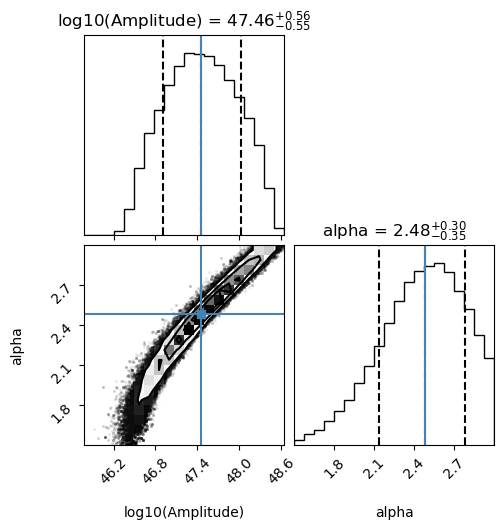

In [1352]:
truth_ic = [item for item in median_values_ic.values()]

## This shows the correlation plot between the parameters
## The lines are the original true values that were used to obtain the models
fig = corner.corner(samples_flat, labels=labels_ic, truths=truth_ic, quantiles=[0.16, 0.5, 0.84], show_titles=True)

muf.save_figures(PlotDir, name='corner_ic')
plt.show()

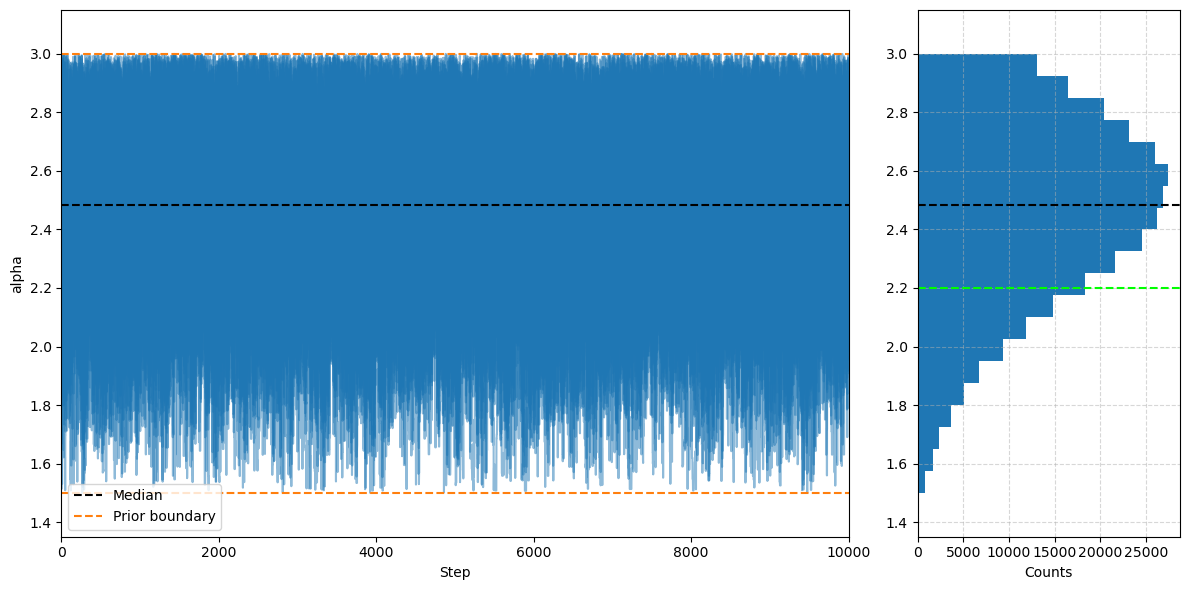

In [1353]:
# Define the prior ranges for each parameter
priors = {
    "log10(Amplitude)": (44, 50),
    "alpha": (1.5, 3),
}

# Loop over each parameter and create a trace plot + distribution plot
for i in range(len(p1_ic)):
    fig = plt.figure(figsize=(12, 6))  # Define overall figure size
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Create a grid layout (3:1 ratio)
    
    # Create trace plot (left panel)
    ax_trace = plt.subplot(gs[0])
    ax_trace.plot(samples_non_flat[:, :, i], "tab:blue", alpha=0.5)

    ax_trace.axhline(y=df_result_ic["Median"][i], color='black', linestyle='--', label='Median')
    
    # Add the prior boundaries as horizontal lines
    param_name = labels_ic[i]  # Get the parameter name from labels_ic
    if param_name in priors:
        prior_min, prior_max = priors[param_name]
        ax_trace.axhline(y=prior_min, color='tab:orange', linestyle='--', label='Prior boundary')
        ax_trace.axhline(y=prior_max, color='tab:orange', linestyle='--')

    ax_trace.set_ylim(prior_min - 0.15, prior_max + 0.15)

    
    # Set labels and limits
    ax_trace.set_xlim(0, len(samples_non_flat))
    ax_trace.set_xlabel("Step")
    ax_trace.set_ylabel(f"{param_name}")
    ax_trace.legend()

    # Create distribution plot (right panel)
    ax_dist = plt.subplot(gs[1], sharey=ax_trace)  # Share y-axis with trace plot
    param_samples = samples_non_flat[:, :, i].flatten()

    ax_dist.hist(param_samples, bins=20, color="tab:blue", orientation="horizontal")  # Histogram
    ax_dist.axhline(y=df_result_ic["Median"][i], color='black', linestyle='--', label='Median')
    ax_dist.axhline(y=p1_ic[i], color='lime', linestyle='--', label='Median')
    
    ax_dist.set_xlabel("Counts")
    ax_dist.yaxis.set_visible(True)  # Ensure the y-axis is visible
    ax_dist.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

    # Show the plot
    plt.tight_layout()

    muf.save_figures(PlotDir, name=f'trace_plot_ic_{param_name}')
    
    plt.show()

In [1354]:
acceptance_fraction = sampler_ic.acceptance_fraction  # Get acceptance rate for each walker
print("Mean Acceptance fraction:", round(np.mean(acceptance_fraction), 2))
print("\n")

low_acceptance_walkers = acceptance_fraction[acceptance_fraction < .2]
high_acceptance_walkers = acceptance_fraction[acceptance_fraction > .5]

print(f"{len(low_acceptance_walkers)} low acceptance walkers: {low_acceptance_walkers}")
print(f"{len(high_acceptance_walkers)} high acceptance walkers: {high_acceptance_walkers}")

Mean Acceptance fraction: 0.49


0 low acceptance walkers: []
0 high acceptance walkers: []


In [1355]:
tau_ic = sampler_ic.get_autocorr_time(tol=.0, quiet=True)
print("Autocorrelation times:", tau_ic)

gl = gelman_rubin(samples_non_flat)
print("Gelman-Rubin coefficients:", gl)

Autocorrelation times: [16.73547961 19.10901201]
Gelman-Rubin coefficients: [1.00009271 1.00029303]


In [1356]:
dict_results = {"Initial_Params": [], "Data_fit": [], "GL_coeff": [], "Tau_cor": [], "Parameter_amplification": []}
dict_results["Initial_Params"].append(p1_ic)
dict_results["Data_fit"].append(df_result_ic)
dict_results["GL_coeff"].append(gl)
dict_results["Tau_cor"].append(tau_ic)
dict_results["Parameter_amplification"].append(parameter_amplification)
df_results = pd.DataFrame(dict_results)

df_results.to_csv("results_fit_ic.csv", index=False)

### Plotting

In [1357]:
e = np.logspace(-10, 3, 400) * gp.TeV_to_erg

# Extract median and error values
param_names_ic = df_result_ic["Parameter"].values
median_values_ic_array = np.array(df_result_ic["Median"].values)
upper_errors_ic = np.array(df_result_ic["Upper Error"].values)
lower_errors_ic = np.array(df_result_ic["Lower Error"].values)

# Compute upper and lower bounds
upper_params_ic = median_values_ic_array + upper_errors_ic  # Upper bound (median + upper error)
lower_params_ic = median_values_ic_array - lower_errors_ic  # Lower bound (median - lower error)

# Compute model fits for boundaries
energy_model_upper_ic, model_upper_ic = ic_model_for_fit(x_ic, *upper_params_ic, return_full=True)
energy_model_lower_ic, model_lower_ic = ic_model_for_fit(x_ic, *lower_params_ic, return_full=True)

energy_model_upper_ic_to_plot, model_upper_ic_to_plot = ic_model_for_fit(e, *upper_params_ic, return_full=True)
energy_model_lower_ic_to_plot, model_lower_ic_to_plot = ic_model_for_fit(e, *lower_params_ic, return_full=True)

In [1358]:
# energy_initial_guess_ic, model_data_initial_guess_ic = ic_model_for_fit(e, *p1_ic, return_full=True)

# chi2_initial_guess_ic, chi2_red_initial_guess_ic = red_chi2(y_ic, ic_model_for_fit(x_ic, *p1_ic, return_full=False), y_ic, len(p1_ic))

# n_res_initial_ic = (y_ic - ic_model_for_fit(x_ic, *p1_ic, return_full=False))
# d_res_initial_ic = ic_model_for_fit(x_ic, *p1_ic, return_full=False)

# residual_initial_ic = n_res_initial_ic/d_res_initial_ic

###########################################################################################################################################################################################

energy_mcmc_fit_ic, model_data_mcmc_fit_ic = ic_model_for_fit(e, *median_values_ic.values(), return_full=True)

chi2_mcmc_ic, chi2_red_mcmc_ic = red_chi2_with_model_error(y_ic, ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False), y_err_ic, model_upper_ic, model_lower_ic, len(median_values_ic.values()))

n_res_mcmc_ic =  (y_ic - ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False))
d_res_mcmc_ic = ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False)

residual_mcmc_ic = n_res_mcmc_ic/np.sqrt(y_err_ic**2 + ((model_upper_ic-model_lower_ic)/2)**2)

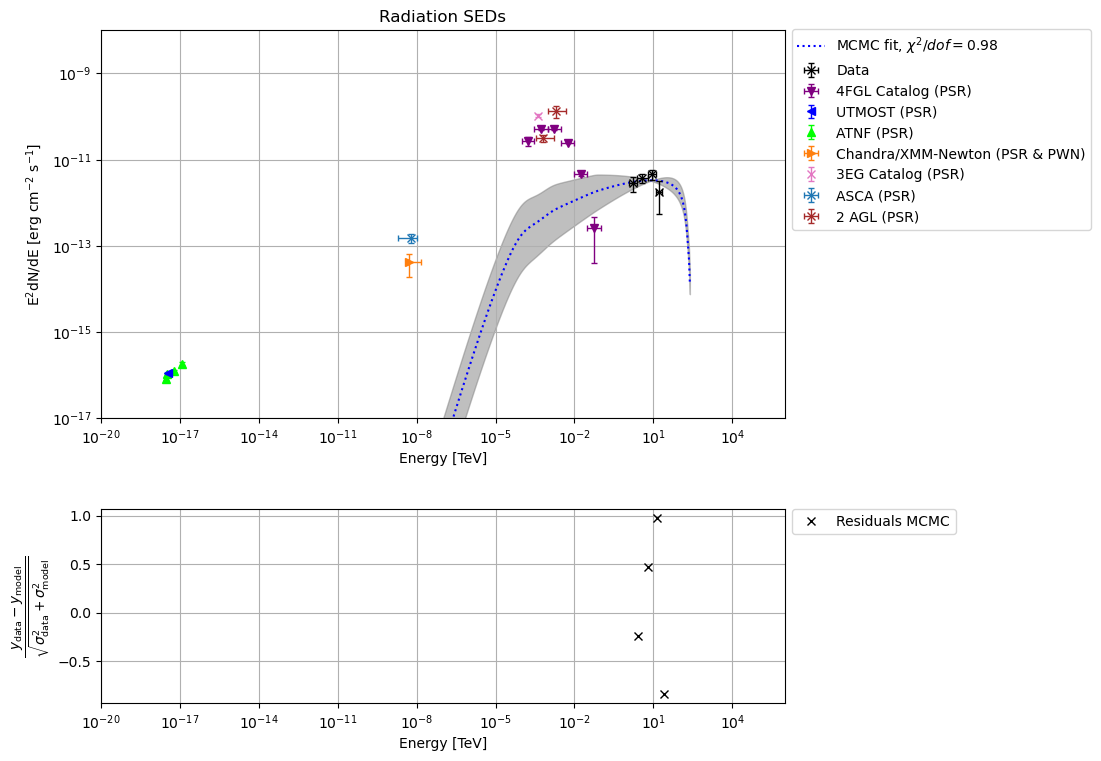

In [1359]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[.5, .25, 1])  

# SED plot
ax2=plt.subplot(gs[0, 0])

# ax2.loglog(energy_initial_guess_ic, model_data_initial_guess_ic, color='black', label=rf'Initial guess, $\chi^2/dof = {chi2_red_initial_guess_ic:.2f}$')

ax2.loglog(energy_mcmc_fit_ic, model_data_mcmc_fit_ic, color='blue', ls=':', label=rf'MCMC fit, $\chi^2/dof = {chi2_red_mcmc_ic:.2f}$')

model_lower_interp = np.interp(energy_model_upper_ic_to_plot, energy_model_lower_ic_to_plot, model_lower_ic_to_plot)
ax2.fill_between(energy_model_upper_ic_to_plot, model_upper_ic_to_plot, model_lower_ic_to_plot, color="gray", alpha=.5)

# Add flux points with error bars
ax2.errorbar(energy, eflux, xerr=energy_mid_err, yerr=eflux_error, fmt='x', color='black', ecolor='black', elinewidth=1, capsize=2, label="Data")

ax2.errorbar(ref_energy_fermi_J1048_5832, flux_e2dnde_fermi_J1048_5832, xerr=ref_energy_fermi_J1048_5832_err, yerr=flux_e2dnde_err_fermi_J1048_5832, fmt='v', color='purple', ecolor='purple', elinewidth=1, capsize=2, label="4FGL Catalog (PSR)")

ax2.errorbar(UTMOST_energy, UTMOST_flux_density_erg, yerr=UTMOST_flux_density_erg_error, fmt='<', color='blue', ecolor='blue', elinewidth=1, capsize=2, label="UTMOST (PSR)", zorder=10) 

ax2.errorbar(atnf_energy, atnf_flux_density_erg, yerr=atnf_flux_density_erg_error, fmt='^', color='lime', ecolor='lime', elinewidth=1, capsize=2, label="ATNF (PSR)") 

ax2.errorbar(energy_chandra, e2dnde_chandra, xerr=energy_chandra_err, yerr=e2dnde_chandra_errors/2, fmt='>', color='tab:orange', ecolor='tab:orange', elinewidth=1, capsize=2, label="Chandra/XMM-Newton (PSR & PWN)")

ax2.errorbar(egret_energy*1e-6, mean_egret_flux_densities_in_erg, yerr=std_egret_flux_densities_in_erg, fmt='x', color='tab:pink', ecolor='tab:pink', elinewidth=1, capsize=2, label="3EG Catalog (PSR)")

ax2.errorbar(asca_energy, asca_flux, xerr=asca_energy_error, yerr=asca_error, fmt='x', color='tab:blue', ecolor='tab:blue', elinewidth=1, capsize=2, label="ASCA (PSR)") # https://iopscience.iop.org/article/10.1086/308139/pdf

ax2.errorbar(energy_mean_agile*1e-3, e2dnde_agile, xerr=agile_energy_error, yerr=e2dnde_agile_error,fmt='x', color='brown', ecolor='brown', elinewidth=1, capsize=2, label="2 AGL (PSR)")

ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel(r"E$^2$dN/dE [erg cm$^{-2}$ s$^{-1}$]")
ax2.set_xlim(xmin=1e-20,xmax=1e6)
ax2.set_ylim(ymin=1e-17,ymax=1e-8)
ax2.set_title("Radiation SEDs")
ax2.legend(bbox_to_anchor=(1,1.02))
ax2.grid()

ax3 = plt.subplot(gs[1, 0])

# ax3.plot(x_ic, residual_initial_ic, '<', color='purple', label='Initial guess IC')

ax3.plot(x_ic, residual_mcmc_ic, 'x', color='black', label='Residuals MCMC')


ax3.set_xscale("log")
ax3.set_xlim(xmin=1e-20,xmax=1e6)
# ax3.set_ylim(ymin=-1,ymax=1)

ax3.legend(bbox_to_anchor=(1.26, 1.035))
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r'$\frac{y_{\text{data}} - y_{\text{model}}}{\sqrt{\sigma_{\text{data}}^2 + \sigma_{\text{model}}^2}}$', fontsize=14)
ax3.grid()

muf.save_figures(PlotDir, name='SED_sync')

plt.show()

## Pion

### Setup

In [237]:
class PP_MCMC_FitProcedure:
    def __init__(self, model_for_fitting):
        self.model_for_fitting = model_for_fitting

    def model_wrapper(self, energy, *params):
        return self.model_for_fitting(energy, *params)

    def log_prior(self, theta):
        """
        Uninformative flat prior.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
        """
        a, b = theta  # extract the parameters
        if 45 < a < 55 and 1.5 < b < 3:
            return 0
        return -np.inf
    
    def log_likelihood(self, theta, x, y, yerr):
        """
        Compute the chi2.
        Needs to be adjusted depending on the chosen parameters
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """

        model = self.model_wrapper(x, *theta) 

        nominator = (y - model)**2
        denominator = yerr**2 
        
        log_l = -0.5 * np.sum(nominator / denominator)
        
        return log_l

    def log_prob(self, theta, x, y, yerr):
        """
        Compute the total log probability.
        
        Arguments:
            - theta : list of parameters
            - x, y, yerr : data points with errorbar
        """
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta, x, y, yerr)

    def run(self, _energy_, _flux_, _flux_error_, _initial_guess_, _burn_in_steps_, _chain_steps_):
        with Pool(processes=4) as pool:
            
            nwalkers, ndim = 30, 2
            
            parameter_amplitudes = 0.01

            print(f"Start the MCMC using {nwalkers} walkers for {ndim} parameters. Parameter amplitude change: {parameter_amplitudes}")
   
            acceptance_range = (0.2, 0.5)

            moves = [
                    (emcee.moves.DEMove(), 0.5), 
                    (emcee.moves.StretchMove(a=1.8), 0.4), 
                    (emcee.moves.WalkMove(), 0.6) 
                    ]
            
            sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_prob, pool=pool, args=(_energy_, _flux_, _flux_error_), moves=moves)

            pos = np.array(_initial_guess_) + parameter_amplitudes * np.random.randn(nwalkers, ndim)  
            
            state = sampler.run_mcmc(pos, _burn_in_steps_, progress=True)  # Burn-in phase

            acceptance = sampler.acceptance_fraction
            mean_acceptance = np.mean(sampler.acceptance_fraction, axis=0)

            low_acceptance_walkers = acceptance[acceptance < acceptance_range[0]]
            high_acceptance_walkers = acceptance[acceptance > acceptance_range[1]]

            print(f"{len(low_acceptance_walkers)} low acceptance walkers: {low_acceptance_walkers}")
            print(f"{len(high_acceptance_walkers)} high acceptance walkers: {high_acceptance_walkers}")

            print(f"\n")
            
            print(f"Mean acceptance: {round(mean_acceptance, 2)} ---> fits, keeping step sizes: {parameter_amplitudes}")
            
            print(f"End burn-in phase")
            
            print(f"\n")
            
            print(f"Step sizes for each parameter: {parameter_amplitudes}")
            sampler.reset()
            
            sampler.run_mcmc(state, _chain_steps_, progress=True) 
            print(f"End MCMC")
        
        return sampler, parameter_amplitudes

In [238]:
# define reference energy as 1 TeV
e_ref = gp.TeV_to_erg

fu = gp.Utils()

def pp_model_for_fit(
    _photon_energy_, 
    a, b,
    return_full=False, 
):
    """
    Build a model for data fitting using a log-parabolic electron injection spectrum.
    
    Parameters:
        _photon_energy_ : array-like
            Array of photon energies (in TeV).
        a, b, c : float
            Parameters of the model to be fitted.
            - a: log10(total energy of particles) in erg.
            - b: spectral index alpha of the log-parabola.
            - c: curvature parameter beta of the log-parabola.
        return_full : bool, optional
            If True, returns full arrays (energies and fluxes). Otherwise, only fluxes.
        distance : float, optional
            Distance to the source in parsecs (default: 2900 pc).
        b_field : float, optional
            Magnetic field strength in Gauss (default: 3e-6 G).   
    Returns:
        np.ndarray
            Flux values for the specified SED type(s).
    """

    distance = 2.9e3  # pc

    # Convert input parameter `a` to total energy in erg
    e_total_logpar = 10**a
    alpha_logpar = b
    beta_logpar = 0

    # Electron energy grid in erg
    energy_in_erg_logpar = np.logspace(0, np.log10(50), 400)*gp.TeV_to_erg

    logparabola = (energy_in_erg_logpar/e_ref)**-(alpha_logpar + beta_logpar * np.log10((energy_in_erg_logpar/e_ref)))
    logparabola *= e_total_logpar / fu.Integrate(list(zip(energy_in_erg_logpar,energy_in_erg_logpar * logparabola)))
    logparabola_spectrum = np.array(list(zip(energy_in_erg_logpar,logparabola)))

    ambient_density = 1 # 1/cm^3
    
    # Initialize radiation module
    fr = gp.Radiation()
    fr.ToggleQuietMode()
    fr.SetAmbientDensity(ambient_density)
    fr.SetDistance(distance)
    fr.SetProtons(logparabola_spectrum)

    # Calculate photon spectra
    fr.CalculateDifferentialPhotonSpectrum(_photon_energy_)

    rad = np.array(fr.GetPPSED())
    return (rad[:, 0], rad[:, 1]) if return_full else rad[:, 1]

### Fit

In [239]:
p1_pp = [50, 2.2]

In [240]:
# Instantiate the MCMC procedure
mcmc_procedure_pp = PP_MCMC_FitProcedure(pp_model_for_fit)

burn_in_steps = 100
total_sampling_steps = 1000

# Run MCMC
sampler_pp, parameter_amplification = mcmc_procedure_pp.run(x_ic, y_ic, y_err_ic, p1_pp, burn_in_steps, total_sampling_steps)

Start the MCMC using 30 walkers for 2 parameters. Parameter amplitude change: 0.01


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.83it/s]


0 low acceptance walkers: []
3 high acceptance walkers: [0.68 0.56 0.54]


Mean acceptance: 0.4 ---> fits, keeping step sizes: 0.01
End burn-in phase


Step sizes for each parameter: 0.01


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.23it/s]

End MCMC


In [241]:
samples_flat = sampler_pp.get_chain(flat=True)
samples_non_flat = sampler_pp.get_chain(flat=False)

In [242]:
labels_pp = ["log10(Amplitude)", "alpha"]#, "log10(edens)"]
# Collect the results into a list
results_pp = []
for i, label in enumerate(labels_pp):
    mcmc = np.percentile(samples_flat[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results_pp.append([label, mcmc[1], q[1], q[0]])

# Create a DataFrame for better formatting
df_result_pp = pd.DataFrame(results_pp, columns=["Parameter", "Median", "Upper Error", "Lower Error"])

# Display the table
print(df_result_pp)

# Create a dpptionary with parameter names as keys and median values as values
median_values_pp = {row["Parameter"]: row["Median"] for _, row in df_result_pp.iterrows()}

          Parameter     Median  Upper Error  Lower Error
0  log10(Amplitude)  49.557806     0.096534     0.123178
1             alpha   1.557225     0.095391     0.042131


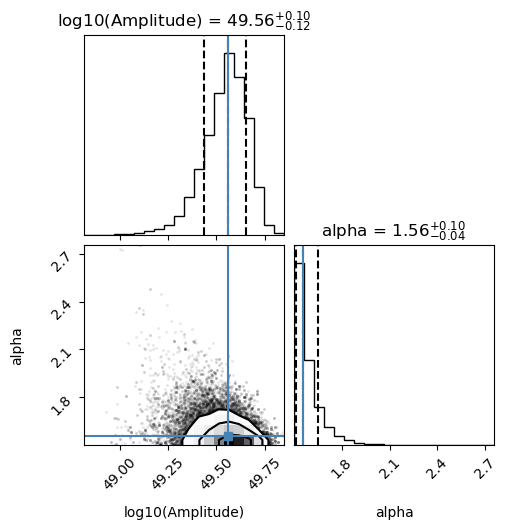

In [243]:
truth_pp = [item for item in median_values_pp.values()]

## This shows the correlation plot between the parameters
## The lines are the original true values that were used to obtain the models
fig = corner.corner(samples_flat, labels=labels_pp, truths=truth_pp, quantiles=[0.16, 0.5, 0.84], show_titles=True)

muf.save_figures(PlotDir, name='corner_pp')
plt.show()

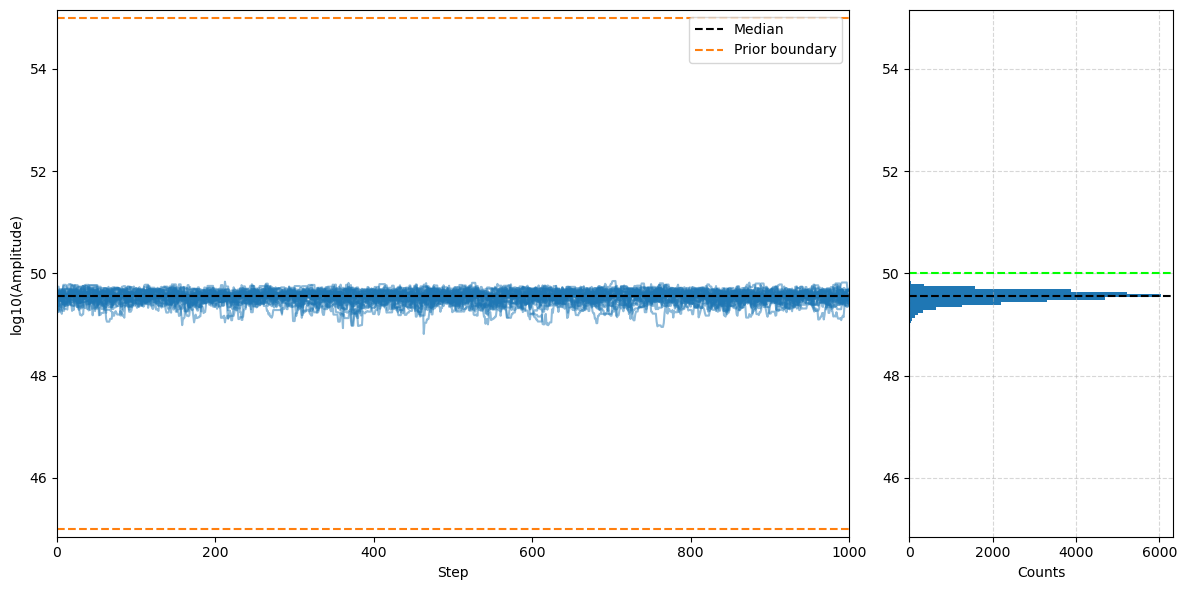

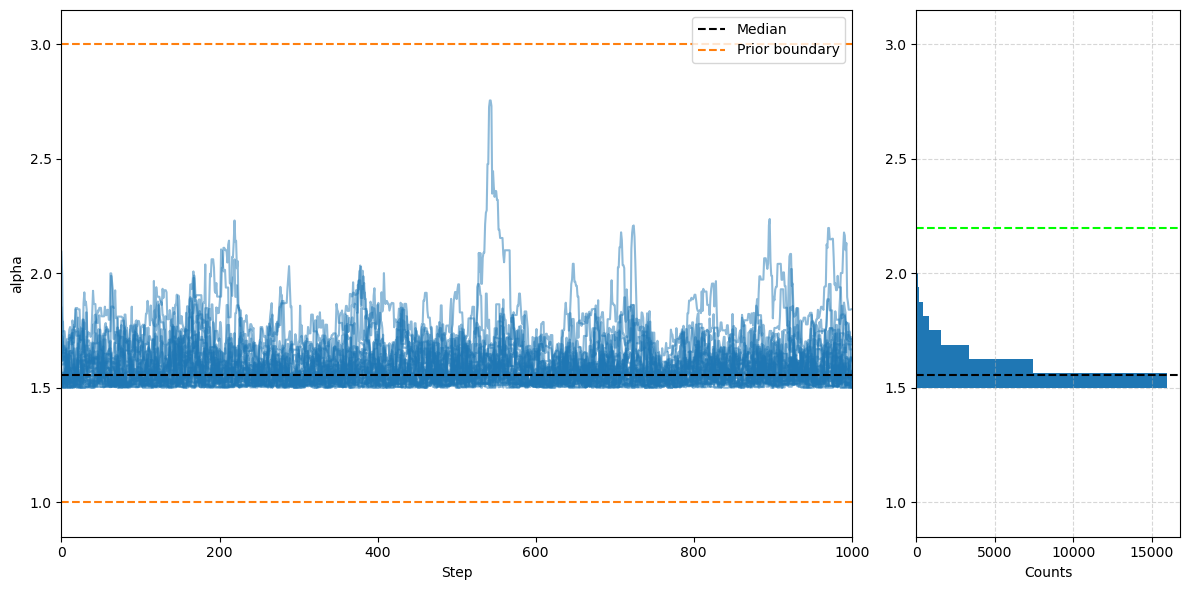

In [244]:
# Define the prior ranges for each parameter
priors = {
    "log10(Amplitude)": (45, 55),
    "alpha": (1, 3),
    # "log10(edens)": (0, 2)
}

# Loop over each parameter and create a trace plot + distribution plot
for i in range(len(p1_pp)):
    fig = plt.figure(figsize=(12, 6))  # Define overall figure size
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Create a grid layout (3:1 ratio)
    
    # Create trace plot (left panel)
    ax_trace = plt.subplot(gs[0])
    ax_trace.plot(samples_non_flat[:, :, i], "tab:blue", alpha=0.5)

    ax_trace.axhline(y=df_result_pp["Median"][i], color='black', linestyle='--', label='Median')
    
    # Add the prior boundaries as horizontal lines
    param_name = labels_pp[i]  # Get the parameter name from labels_pp
    if param_name in priors:
        prior_min, prior_max = priors[param_name]
        ax_trace.axhline(y=prior_min, color='tab:orange', linestyle='--', label='Prior boundary')
        ax_trace.axhline(y=prior_max, color='tab:orange', linestyle='--')

    ax_trace.set_ylim(prior_min - 0.15, prior_max + 0.15)

    
    # Set labels and limits
    ax_trace.set_xlim(0, len(samples_non_flat))
    ax_trace.set_xlabel("Step")
    ax_trace.set_ylabel(f"{param_name}")
    ax_trace.legend()

    # Create distribution plot (right panel)
    ax_dist = plt.subplot(gs[1], sharey=ax_trace)  # Share y-axis with trace plot
    param_samples = samples_non_flat[:, :, i].flatten()

    ax_dist.hist(param_samples, bins=20, color="tab:blue", orientation="horizontal")  # Histogram
    ax_dist.axhline(y=df_result_pp["Median"][i], color='black', linestyle='--', label='Median')
    ax_dist.axhline(y=p1_pp[i], color='lime', linestyle='--', label='Median')
    
    ax_dist.set_xlabel("Counts")
    ax_dist.yaxis.set_visible(True)  # Ensure the y-axis is visible
    ax_dist.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

    # Show the plot
    plt.tight_layout()

    muf.save_figures(PlotDir, name=f'trace_plot_pp_{param_name}')
    
    plt.show()

In [245]:
tau_pp = sampler_pp.get_autocorr_time(tol=.0, quiet=True)
print("Autocorrelation times:", tau_pp)

gl = gelman_rubin(samples_non_flat)
print("Gelman-Rubin coeffppients:", gl)

Autocorrelation times: [16.18521745 19.20091549]
Gelman-Rubin coeffppients: [1.0005629  1.00168349]


In [246]:
dict_results = {"Initial_Params": [], "Data_fit": [], "GL_coeff": [], "Tau_cor": [], "Parameter_amplification": []}
dict_results["Initial_Params"].append(p1_pp)
dict_results["Data_fit"].append(df_result_pp)
dict_results["GL_coeff"].append(gl)
dict_results["Tau_cor"].append(tau_pp)
dict_results["Parameter_amplification"].append(parameter_amplification)
df_results = pd.DataFrame(dict_results)

df_results.to_csv("results_fit_pp.csv", index=False)

## Together

In [1360]:
e = np.logspace(-20, 3, 400) * gp.TeV_to_erg

#### Sync

In [1342]:
energy_mcmc_fit_sync, model_data_mcmc_fit_sync = sync_model_for_fit(e, *median_values_sync.values(), return_full=True)

chi2_mcmc_sync, chi2_red_mcmc_sync = red_chi2_with_model_error(y_sync, sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False), y_err_sync, model_upper, model_lower, len(median_values_sync.values()))

n_res_mcmc_sync =  (y_sync - sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False))
d_res_mcmc_sync = sync_model_for_fit(x_sync, *median_values_sync.values(), return_full=False)

residual_mcmc_sync = n_res_mcmc_sync/np.sqrt(y_err_sync**2 + ((model_upper-model_lower)/2)**2)

#### Sync + IC

In [1361]:
energy_mcmc_fit_ic, model_data_mcmc_fit_ic = ic_model_for_fit(e, *median_values_ic.values(), return_full=True)

chi2_mcmc_ic, chi2_red_mcmc_ic = red_chi2_with_model_error(y_ic, ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False), y_err_ic, model_upper_ic, model_lower_ic, len(median_values_ic.values()))

n_res_mcmc_ic =  (y_ic - ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False))
d_res_mcmc_ic = ic_model_for_fit(x_ic, *median_values_ic.values(), return_full=False)

residual_mcmc_ic = n_res_mcmc_ic/np.sqrt(y_err_ic**2 + ((model_upper_ic-model_lower_ic)/2)**2)

In [1362]:
df_sync = pd.DataFrame({'energy': energy_mcmc_fit_sync, 'model_sync': model_data_mcmc_fit_sync})
df_ic = pd.DataFrame({'energy': energy_mcmc_fit_ic, 'model_ic': model_data_mcmc_fit_ic})

# Merge using an outer join to keep all energies
df_combined_sync_ic = df_sync.merge(df_ic, on='energy', how='outer')

# Fill NaNs with 0 to avoid NaN issues in summation
df_combined_sync_ic.fillna(0, inplace=True)

# Sum the y-values
df_combined_sync_ic['model_total'] = df_combined_sync_ic['model_sync'] + df_combined_sync_ic['model_ic']

#### Sync + PP

In [247]:
energy_mcmc_fit_pp, model_data_mcmc_fit_pp = pp_model_for_fit(e, *median_values_pp.values(), return_full=True)

chi2_mcmc_pp, chi2_red_mcmc_pp = red_chi2(y_ic, pp_model_for_fit(x_ic, *median_values_pp.values(), return_full=False), y_ic, len(median_values_pp.values()))

n_res_mcmc_pp =  (y_ic - pp_model_for_fit(x_ic, *median_values_pp.values(), return_full=False))
d_res_mcmc_pp = pp_model_for_fit(x_ic, *median_values_pp.values(), return_full=False)

residual_mcmc_pp = n_res_mcmc_pp/d_res_mcmc_pp

In [248]:
df_sync = pd.DataFrame({'energy': energy_mcmc_fit_sync, 'model_sync': model_data_mcmc_fit_sync})
df_pp = pd.DataFrame({'energy': energy_mcmc_fit_pp, 'model_pp': model_data_mcmc_fit_pp})

# Merge using an outer join to keep all energies
df_combined_sync_pp = df_sync.merge(df_pp, on='energy', how='outer')

# Fill NaNs with 0 to avoid NaN issues in summation
df_combined_sync_pp.fillna(0, inplace=True)

# Sum the y-values
df_combined_sync_pp['model_total'] = df_combined_sync_pp['model_sync'] + df_combined_sync_pp['model_pp']

#### Plotting

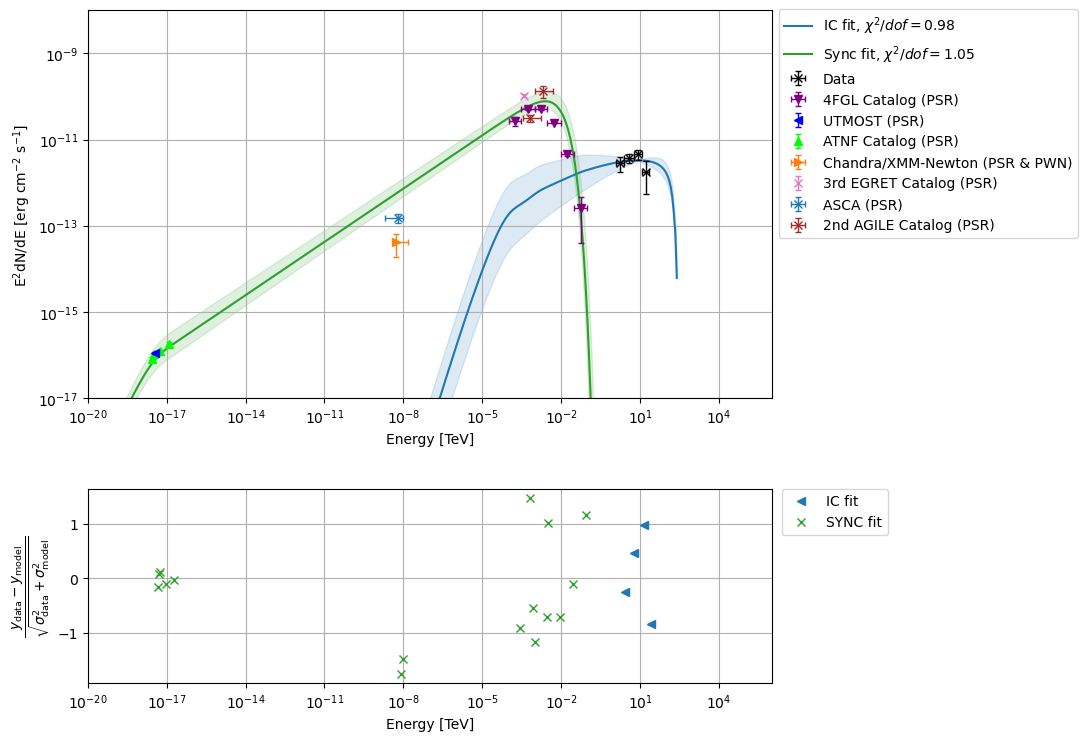

In [1374]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[.5, .25, 1])  

# SED plot
ax2=plt.subplot(gs[0, 0])


ax2.loglog(energy_mcmc_fit_ic, model_data_mcmc_fit_ic, color='tab:blue', label=rf'IC fit, $\chi^2/dof = {chi2_red_mcmc_ic:.2f}$')

model_lower_interp = np.interp(energy_model_upper_ic_to_plot, energy_model_lower_ic_to_plot, model_lower_ic_to_plot)
ax2.fill_between(energy_model_upper_ic_to_plot, model_upper_ic_to_plot, model_lower_ic_to_plot, color="tab:blue", alpha=.15)

ax2.loglog(energy_mcmc_fit_sync, model_data_mcmc_fit_sync, color='tab:green', label=rf'Sync fit, $\chi^2/dof = {chi2_red_mcmc_sync:.2f}$')

model_lower_interp = np.interp(energy_model_upper_to_plot, energy_model_lower_to_plot, model_lower_to_plot)
ax2.fill_between(energy_model_upper_to_plot, model_upper_to_plot, model_lower_interp, color="tab:green", alpha=.15)

# ax2.loglog(energy_mcmc_fit_pp, model_data_mcmc_fit_pp, color='tab:orange', label=rf'PP MCMC fit, $\chi^2/dof = {chi2_red_mcmc_pp:.2f}$')


# ax2.loglog(df_combined_sync_ic['energy'], df_combined_sync_ic['model_total'], color='black', linestyle=':', label=rf'Total SED Sync + IC')



# ax2.loglog(df_combined_sync_pp['energy'], df_combined_sync_pp['model_total'], color='purple', linestyle=':', label=rf'Total SED Sync + PP')

# ax2.loglog(df_combined['energy'], df_combined['model_total'], color='black', linestyle='solid', label=rf'Total SED Sync + IC + PP')

# Add flux points with error bars
ax2.errorbar(energy, eflux, xerr=energy_mid_err, yerr=eflux_error, fmt='x', color='black', ecolor='black', elinewidth=1, capsize=2, label="Data")

ax2.errorbar(ref_energy_fermi_J1048_5832, flux_e2dnde_fermi_J1048_5832, xerr=ref_energy_fermi_J1048_5832_err, yerr=flux_e2dnde_err_fermi_J1048_5832, fmt='v', color='purple', ecolor='purple', elinewidth=1, capsize=2, label="4FGL Catalog (PSR)")

ax2.errorbar(UTMOST_energy, UTMOST_flux_density_erg, yerr=UTMOST_flux_density_erg_error, fmt='<', color='blue', ecolor='blue', elinewidth=1, capsize=2, label="UTMOST (PSR)", zorder=10) 

ax2.errorbar(atnf_energy, atnf_flux_density_erg, yerr=atnf_flux_density_erg_error, fmt='^', color='lime', ecolor='lime', elinewidth=1, capsize=2, label="ATNF Catalog (PSR)") 

ax2.errorbar(energy_chandra, e2dnde_chandra, xerr=energy_chandra_err, yerr=e2dnde_chandra_errors/2, fmt='>', color='tab:orange', ecolor='tab:orange', elinewidth=1, capsize=2, label="Chandra/XMM-Newton (PSR & PWN)")

ax2.errorbar(egret_energy*1e-6, mean_egret_flux_densities_in_erg, yerr=std_egret_flux_densities_in_erg, fmt='x', color='tab:pink', ecolor='tab:pink', elinewidth=1, capsize=2, label="3rd EGRET Catalog (PSR)")

ax2.errorbar(asca_energy, asca_flux, xerr=asca_energy_error, yerr=asca_error, fmt='x', color='tab:blue', ecolor='tab:blue', elinewidth=1, capsize=2, label="ASCA (PSR)") # https://iopscience.iop.org/article/10.1086/308139/pdf

ax2.errorbar(energy_mean_agile*1e-3, e2dnde_agile, xerr=agile_energy_error, yerr=e2dnde_agile_error,fmt='x', color='brown', ecolor='brown', elinewidth=1, capsize=2, label="2nd AGILE Catalog (PSR)")

ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel(r"E$^2$dN/dE [erg cm$^{-2}$ s$^{-1}$]")
ax2.set_xlim(xmin=1e-20,xmax=1e6)
ax2.set_ylim(ymin=1e-17,ymax=1e-8)
ax2.legend(bbox_to_anchor=(1,1.02))
ax2.grid()

ax3 = plt.subplot(gs[1, 0])

ax3.plot(x_ic, residual_mcmc_ic, '<', color='tab:blue', label='IC fit')

ax3.plot(x_sync, residual_mcmc_sync, 'x', color='tab:green', label='SYNC fit')

# ax3.plot(x_ic, residual_mcmc_pp, 'o', color='tab:orange', label='Residuals PP MCMC')

ax3.set_xscale("log")
ax3.set_xlim(xmin=1e-20,xmax=1e6)
# ax3.set_ylim(ymin=-1,ymax=1)

ax3.legend(bbox_to_anchor=(1.18, 1.035))
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r'$\frac{y_{\text{data}} - y_{\text{model}}}{\sqrt{\sigma_{\text{data}}^2 + \sigma_{\text{model}}^2}}$', fontsize=14)
ax3.grid()

muf.save_figures(PlotDir, name='SED_individual_fits')

plt.show()